In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
accel = pd.read_csv('acc.csv', header=None)
accel.columns = ['time','ax','ay','az']
gyro = pd.read_csv('gyro.csv', header=None)
gyro.columns = ['time','gx','gy','gz']
mag = pd.read_csv('mag.csv', header=None)
mag.columns = ['time','mx','my','mz']
true_data = pd.read_csv('true.csv', header=None)
true_data.columns = ['time','roll','pitch','yaw']

In [9]:
# x for nn is acc, gyro, mag
# y for nn is true_data
x = pd.concat([accel[['ax','ay','az']], gyro[['gx','gy','gz']], mag[['mx','my','mz']]], axis=1)
y = true_data[['roll','pitch','yaw']]
# add noise to x
noise = np.random.normal(0, 0.1, x.shape)
x += noise

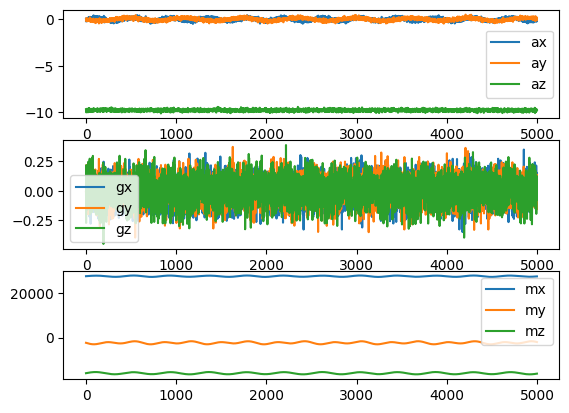

In [10]:
# plot data
plt.figure(1)
plt.subplot(311)
plt.plot(x['ax'], label='ax')
plt.plot(x['ay'], label='ay')
plt.plot(x['az'], label='az')
plt.legend()
plt.subplot(312)    
plt.plot(x['gx'], label='gx')
plt.plot(x['gy'], label='gy')
plt.plot(x['gz'], label='gz')
plt.legend()
plt.subplot(313)
plt.plot(x['mx'], label='mx')
plt.plot(x['my'], label='my')
plt.plot(x['mz'], label='mz')
plt.legend()
plt.show()

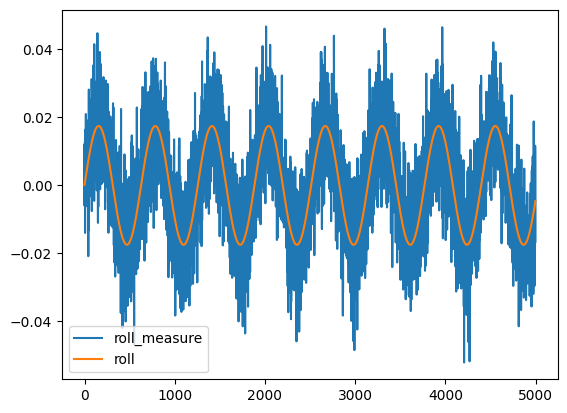

In [12]:
# measure data
roll_measure = np.zeros(len(x))
pitch_measure = np.zeros(len(x))
yaw_measure = np.zeros(len(x))

# calculate roll, pitch, yaw
for i in range(len(x)):
    ax = x['ax'][i]
    ay = x['ay'][i]
    az = x['az'][i]
    mx = x['mx'][i]
    my = x['my'][i]
    mz = x['mz'][i]
    roll_measure[i] = np.arctan2(-ay, -az)
    pitch_measure[i] = np.arcsin(ax/9.8)
    yaw_measure[i] = np.arctan2(-np.cos(roll_measure[i])*my + np.sin(roll_measure[i])*mz, np.cos(pitch_measure[i])*mx + np.sin(pitch_measure[i])*np.sin(roll_measure[i])*my + np.sin(pitch_measure[i])*np.cos(roll_measure[i])*mz)-4.0266*np.pi/180
# plot data vs measure
plt.figure(2)
plt.plot(roll_measure, label='roll_measure')
plt.plot(y['roll'], label='roll')
plt.legend()
plt.show()

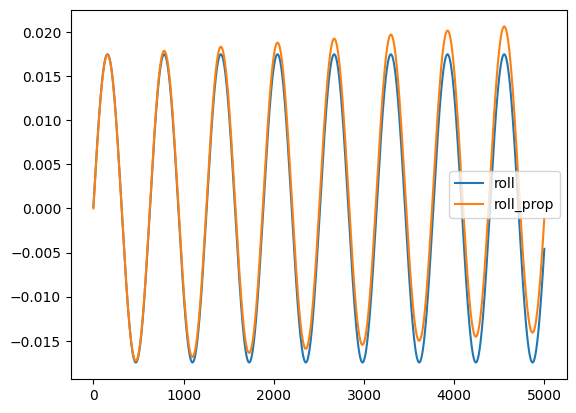

In [14]:
# propagation data
roll_prop = np.zeros(len(x))
pitch_prop = np.zeros(len(x))
yaw_prop = np.zeros(len(x))
roll_prop[0] = 0
pitch_prop[0] = 0
yaw_prop[0] = 0
for i in range(1, len(x)):
    dt = accel['time'][i] - accel['time'][i-1]
    roll_prop[i] = roll_prop[i-1] + dt*(gyro['gx'][i] + np.sin(roll_prop[i-1])*np.tan(pitch_prop[i-1])*gyro['gy'][i] + np.cos(roll_prop[i-1])*np.tan(pitch_prop[i-1])*gyro['gz'][i])
    pitch_prop[i] = pitch_prop[i-1] + dt*(np.cos(roll_prop[i-1])*gyro['gy'][i] - np.sin(roll_prop[i-1])*gyro['gz'][i])
    yaw_prop[i] = yaw_prop[i-1] + dt*(np.sin(roll_prop[i-1])/np.cos(pitch_prop[i-1])*gyro['gy'][i] + np.cos(roll_prop[i-1])/np.cos(pitch_prop[i-1])*gyro['gz'][i])
# plot data vs propagation
plt.figure(3)
plt.plot(y['roll'], label='roll')
plt.plot(roll_prop, label='roll_prop')
plt.legend()
plt.show()

In [16]:
# x ---> measurement + propagation
# y ---> true_data
x = pd.concat([pd.DataFrame([roll_measure, pitch_measure, yaw_measure]).T, pd.DataFrame([roll_prop, pitch_prop, yaw_prop]).T], axis=1)
y = true_data[['roll','pitch','yaw']]
print(y)
# prepare data for nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# build nn
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(32, input_shape=(6,), activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(3))
model.compile(optimizer=Adam(lr=0.001), loss='mse')
model.summary()

          roll     pitch       yaw
0     0.000175  0.000262  0.014045
1     0.000349  0.000524  0.014394
2     0.000524  0.000785  0.014743
3     0.000698  0.001047  0.015091
4     0.000872  0.001308  0.015439
...        ...       ...       ...
4995 -0.005249 -0.007721  0.003684
4996 -0.005082 -0.007485  0.003972
4997 -0.004915 -0.007248  0.004264
4998 -0.004747 -0.007009  0.004559
4999 -0.004579 -0.006768  0.004858

[5000 rows x 3 columns]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                224       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total

In [24]:
# train nn
history = model.fit(x, y, epochs=100, validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 0s 2ms/step - loss: 7.7906e-08 - val_loss: 4.2498e-08
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 8.9344e-08 - val_loss: 7.1696e-08
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 1.9753e-07 - val_loss: 1.5527e-07
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 6.1166e-08 - val_loss: 3.7125e-08
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 7.4359e-08 - val_loss: 1.2005e-07
Epoch 6/100
125/125 [==============================] - 0s 4ms/step - loss: 8.9313e-08 - val_loss: 1.4435e-07
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 6.8929e-08 - val_loss: 3.8209e-08
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 6.3323e-08 - val_loss: 5.8015e-08
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 5.7633e-08 - val_loss: 5.1138e-08
Epoch 10/100
125/12

157/157 [==============================] - 0s 1ms/step


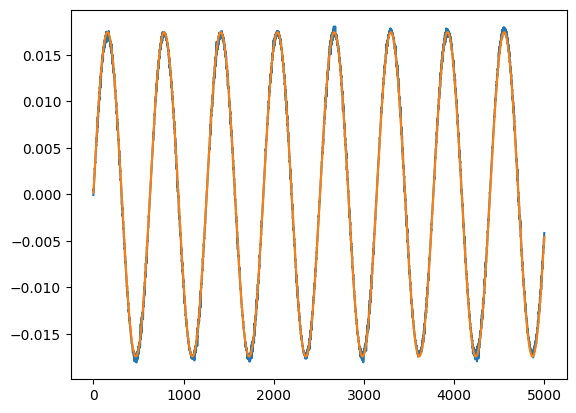

In [26]:
# predict
y_pred = model.predict(x)
# plot data vs predict
plt.figure(4)
plt.plot(y_pred[:,0], label='roll_pred')
plt.plot(y['roll'], label='roll')



In [10]:
# normalize data
x_mean = x.mean()
x_std = x.std()
x = (x - x_mean) / x_std
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [16]:
# make LSTM neuarl network
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(9, 1)))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# reshape x and y   
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], 9, 1)
y = y.reshape(y.shape[0], 3, 1)

In [18]:
# fit model
model.fit(x, y, epochs=10, verbose=1)

Epoch 1/10
157/157 [==============================] - 4s 7ms/step - loss: 0.8155
Epoch 2/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6759
Epoch 3/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6718
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.6687
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.6675
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6672
Epoch 7/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6670
Epoch 8/10
157/157 [==============================] - 1s 8ms/step - loss: 0.6670
Epoch 9/10
157/157 [==============================] - 1s 9ms/step - loss: 0.6669
Epoch 10/10
157/157 [==============================] - 1s 7ms/step - loss: 0.6669


In [ ]:
# save model
model.save('model_AI_AHRS.h5')

In [26]:

x_mean = np.array(x_mean)
x_std = np.array(x_std)
y_mean = np.array(y_mean)
y_std = np.array(y_std)

print(x_mean.shape)
print(x_std.shape)
print(y_mean.shape)
print(y_std.shape)



(9,)
(9,)
(3,)
(3,)


157/157 [==============================] - 1s 3ms/step


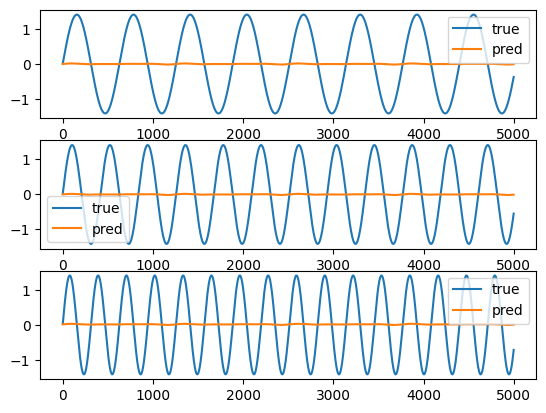

In [27]:
# predict
y_pred = model.predict(x)
# denormalize
x = x.reshape(x.shape[0], 9)
x = x * x_std + x_mean
y = y.reshape(y.shape[0], 3)
y_pred = y_pred * y_std + y_mean

# plot result
plt.figure(2)
plt.subplot(311)
plt.plot(y[:,0], label='true')
plt.plot(y_pred[:,0], label='pred')
plt.legend()
plt.subplot(312)
plt.plot(y[:,1], label='true')
plt.plot(y_pred[:,1], label='pred')
plt.legend()
plt.subplot(313)
plt.plot(y[:,2], label='true')
plt.plot(y_pred[:,2], label='pred')
plt.legend()
plt.show()
